In [21]:
import numpy as np
from tifffile import imread, imwrite
import os
from os.path import isfile, join

dir = "/sps/lsst/users/boutigny/ML/DC2/yoloTrain-gri-16bits/images"

In [3]:
def MTF(x, m):
    M = np.empty(x.shape)
    M.fill(m)
    a = np.equal(x,0.5)*0.5
    b = 1-np.equal(x,0)
    c = np.equal(x,1)
    e = a*b+c
    d = (M-1)*x/((2*M-1)*x - M)
    d[np.isnan(d)]=e[np.isnan(d)]
    return d

In [4]:
def Clip(x, s, h):
    S = np.empty(x.shape)
    S.fill(s)
    H = np.empty(x.shape)
    H.fill(h)
    res = np.empty(x.shape)
    a = 1-np.less(x, S)
    b = np.greater(x, H)
    return np.clip((x-S)/(H-S)*a + b, 0, 1)

In [5]:
def Expansion(x, l, r):
    L = np.empty(x.shape)
    L.fill(l)
    R = np.empty(x.shape)
    R.fill(r)
    return (x-L)/(R-L)

In [6]:
def DF(x, m, s, h, l, r):
    return Expansion(MTF(Clip(x, s, h), m), l, r)

In [35]:
tif = "3452_4,5.tif"
imfile = dir + "/" + tif
image = imread(imfile)

In [53]:
g = image[:,:,0]
r = image[:,:,1]
i = image[:,:,2]

In [54]:
# image should be normalized before stretching
norm = np.max(image)*1.05

In [55]:
g = g/norm
r = r/norm
i = i/norm

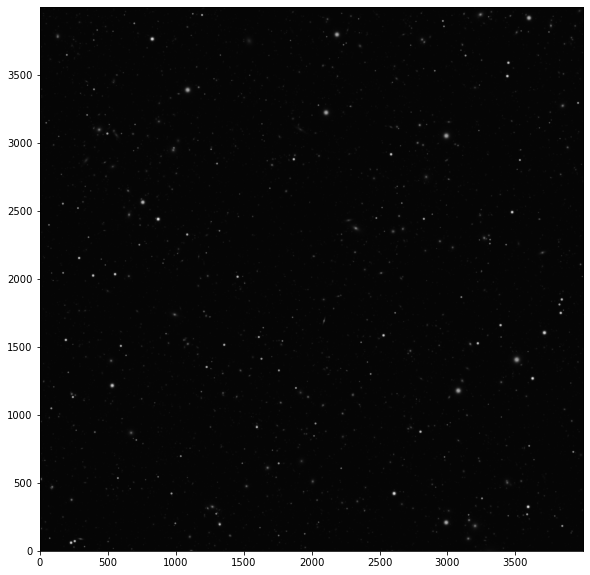

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

from astropy.visualization import AsinhStretch, MinMaxInterval
from astropy.visualization.mpl_normalize import ImageNormalize

plt.figure(figsize=(10,10))

st = 1.e-3    # c'est un paramètre qui fixe la forme de la réponse asinh
#norm = ImageNormalize(vmin=vMin, vmax=vMax, stretch=AsinhStretch(st))
norm = ImageNormalize(r, interval=MinMaxInterval(), stretch=AsinhStretch(st))
plt.imshow(r, origin='lower', norm=norm, cmap = "gray")

In [60]:
def ADpar(data):
    Mc = np.median(data)
    ordered = np.sort(np.absolute(data.ravel()-Mc))
    MADNc = 1.4826*np.median(ordered)
    B = 0.25    # Target mean background
    C = -2.8    # Clipping point in units of MADN 

    if Mc <= 0.5:
        ac = 0
    else:
        ac = 1
    
# Compute the clipping points
    if ac == 1 or MADNc == 0:
        sc = 0
    else:
        sc = min([1, max([0, Mc+C*MADNc])])
    
    if ac == 0 or MADNc == 0:
        hc = 1
    else:
        hc = min([1, max([0, Mc-C*MADNc])])
    
# Compute midtones balance
    if ac == 0:
        mc = (B-1)*(Mc-sc)/((2*B-1)*(Mc-sc)-B)
    else:
        mc = (hc-Mc-1)*B/(2*(hc-Mc-1)*B-(hc-Mc))
        
    lc = 0
    rc = 1
        
    return mc, sc, hc, lc, rc

In [63]:
mc, sc, hc, lc, rc = ADpar(r)
print(mc, sc, hc, lc ,rc)
y = DF(r, mc, sc, hc, lc, rc)

0.00019000644622924493 0.0012307925415039063 1 0 1


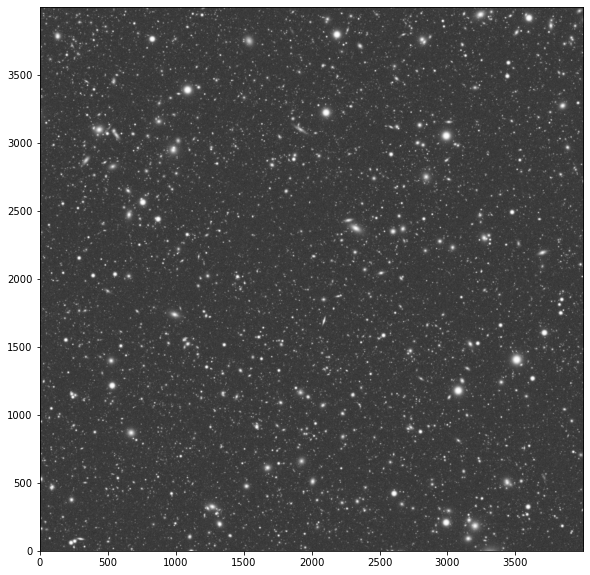

In [64]:
plt.figure(figsize=(10,10))
plt.imshow(y, origin='lower', cmap="gray")

In [65]:
# Try with RGB color planes

In [67]:
mg, sg, hg, lg, rg = ADpar(g)
mr, sr, hr, lr, rr = ADpar(r)
mi, si, hi, li, ri = ADpar(i)
sRGB = (sg + sr + si)/3
hRGB = (hg + hr + hi)/3
mRGB = (mg + mr + mi)/3
yg = DF(g, mRGB, sRGB, hRGB, 0, 1)
yr = DF(r, mRGB, sRGB, hRGB, 0, 1)
yi = DF(i, mRGB, sRGB, hRGB, 0, 1)

In [73]:
#Apparently we need to reverse the color planes
sImage = np.empty(image.shape)
sImage[:,:,0] = yi
sImage[:,:,1] = yr
sImage[:,:,2] = yg

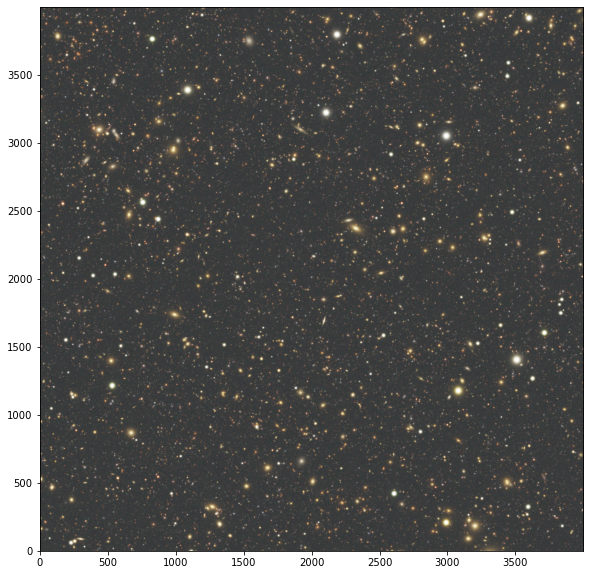

In [74]:
plt.figure(figsize=(10,10))
plt.imshow(sImage, origin='lower')